In [5]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from ase.io import read as read_ase
import icet
import re
import math
import sys

# find files 

In [2]:
simulation_folder = '/nfshome/winkelmann/CathodeSimulationResults/Lichtenberg_250603/'

simulation_concentrations = glob.glob(simulation_folder + 'Va_*')

structure_files = {}
for conc in simulation_concentrations:
    concentration = 100 - float(conc.split('/')[-1].strip('Va_'))
    if concentration == 13:
        concentration = 12.5
    elif concentration == 63:
        concentration = 62.5
    elif concentration == 88:
        concentration = 87.5
    structure_files[str(concentration)] = glob.glob(conc + '/*/kmc_Cathode_Ovito.XDATCAR')

In [4]:
#reading structure and labels
def parse_xdatcar_labels(path):
    """Return list of (step:int, time:float, label:str) in file order."""
    pattern = re.compile(r'step\s+(\d+)\s+time\s+([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)\s*s', re.IGNORECASE)
    labels = []
    with open(path, 'r') as file:
        for line in file:
            label_split = pattern.search(line)
            if label_split:
                step = int(label_split.group(1))
                time = float(label_split.group(2))
                labels.append((step, time, label_split.group(0)))
    return labels

def read_xdatcar_with_labels(path):
    """
    Read XDATCAR-like file and return a DataFrame with columns:
      'step' (int), 'time' (float), 'label' (str), 'atoms' (ase.Atoms)
    """
    labels = parse_xdatcar_labels(path)
    structures = read_ase(path, index=':')   # list of Atoms for all frames
    if len(labels) != len(structures):
        raise ValueError(f"label/frame count mismatch for {path}: {len(labels)} labels vs {len(structures)} frames")
    rows = []
    for (step, time, label), atoms in zip(labels, structures):
        rows.append({'step': step, 'time': time, 'label': label, 'atoms': atoms})
    return pd.DataFrame(rows)

structures_and_labels = {}
for conc, files in structure_files.items():
    structures_and_labels[conc] = pd.DataFrame()
    for run in files:
        sim = read_xdatcar_with_labels(run)
        structures_and_labels[conc] = pd.concat([structures_and_labels[conc], sim], ignore_index=True)
    print(f"Finished reading structures for concentration {conc}%.")       

Finished reading structures for concentration 75.0%.
Finished reading structures for concentration 50.0%.
Finished reading structures for concentration 46.0%.
Finished reading structures for concentration 40.0%.
Finished reading structures for concentration 33.0%.
Finished reading structures for concentration 25.0%.
Finished reading structures for concentration 62.5%.
Finished reading structures for concentration 12.5%.
Finished reading structures for concentration 87.5%.


# translate structure to energy

In [7]:
# calculate energies using cluster expansion and saving them as file
cluster_expansion_file = glob.glob(simulation_folder + '/program_files/mixing_energy_anchorTS_elasticnet.ce')
cluster_expansion = icet.ClusterExpansion.read(cluster_expansion_file[0])
for conc, structures_and_labels_dfs in structures_and_labels.items():
    energies = []
    for idx, structure in enumerate(structures_and_labels_dfs['atoms']):
        sys.stdout.write(f"\rProgress for {conc}%: {((idx+1)/len(structures_and_labels_dfs['atoms']))*100:.2f}% done")
        sys.stdout.flush()
        no_formula_units = [i for i,s in enumerate(structure.get_chemical_symbols()) if s == 'Ni']
        energies.append(cluster_expansion.predict(structure) * len(structure) / len(no_formula_units))       
    structures_and_labels_dfs['energy_per_formula_unit'] = energies
    structures_and_labels_dfs.sort_values(by='time', inplace=True)
    structures_and_labels_dfs.reset_index(drop=True, inplace=True)
    structures_and_labels_dfs.to_csv(f'{simulation_folder}all_energies_conc_{conc}.csv', columns=['step', 'time', 'energy_per_formula_unit'], index=False)
    print(f"\nFinished calculating energies for concentration {conc}%.")

Progress for 75.0%: 100.00% done
Finished calculating energies for concentration 75.0%.
Progress for 50.0%: 100.00% done
Finished calculating energies for concentration 50.0%.
Progress for 46.0%: 100.00% done
Finished calculating energies for concentration 46.0%.
Progress for 40.0%: 100.00% done
Finished calculating energies for concentration 40.0%.
Progress for 33.0%: 100.00% done
Finished calculating energies for concentration 33.0%.
Progress for 25.0%: 100.00% done
Finished calculating energies for concentration 25.0%.
Progress for 62.5%: 100.00% done
Finished calculating energies for concentration 62.5%.
Progress for 12.5%: 100.00% done
Finished calculating energies for concentration 12.5%.
Progress for 87.5%: 100.00% done
Finished calculating energies for concentration 87.5%.


# with finished energie files!

In [11]:
#read files
files_to_process = glob.glob(simulation_folder + 'all_energies_conc_*.csv')
energies_and_time = {}
print(files_to_process)
for file in files_to_process:
    df = pd.read_csv(file)
    conc = file.split('_')[-1].strip('.csv')
    energies_and_time[conc] = df

['/nfshome/winkelmann/CathodeSimulationResults/Lichtenberg_250603/all_energies_conc_75.0.csv', '/nfshome/winkelmann/CathodeSimulationResults/Lichtenberg_250603/all_energies_conc_50.0.csv', '/nfshome/winkelmann/CathodeSimulationResults/Lichtenberg_250603/all_energies_conc_46.0.csv', '/nfshome/winkelmann/CathodeSimulationResults/Lichtenberg_250603/all_energies_conc_40.0.csv', '/nfshome/winkelmann/CathodeSimulationResults/Lichtenberg_250603/all_energies_conc_33.0.csv', '/nfshome/winkelmann/CathodeSimulationResults/Lichtenberg_250603/all_energies_conc_25.0.csv', '/nfshome/winkelmann/CathodeSimulationResults/Lichtenberg_250603/all_energies_conc_62.5.csv', '/nfshome/winkelmann/CathodeSimulationResults/Lichtenberg_250603/all_energies_conc_12.5.csv', '/nfshome/winkelmann/CathodeSimulationResults/Lichtenberg_250603/all_energies_conc_87.5.csv']


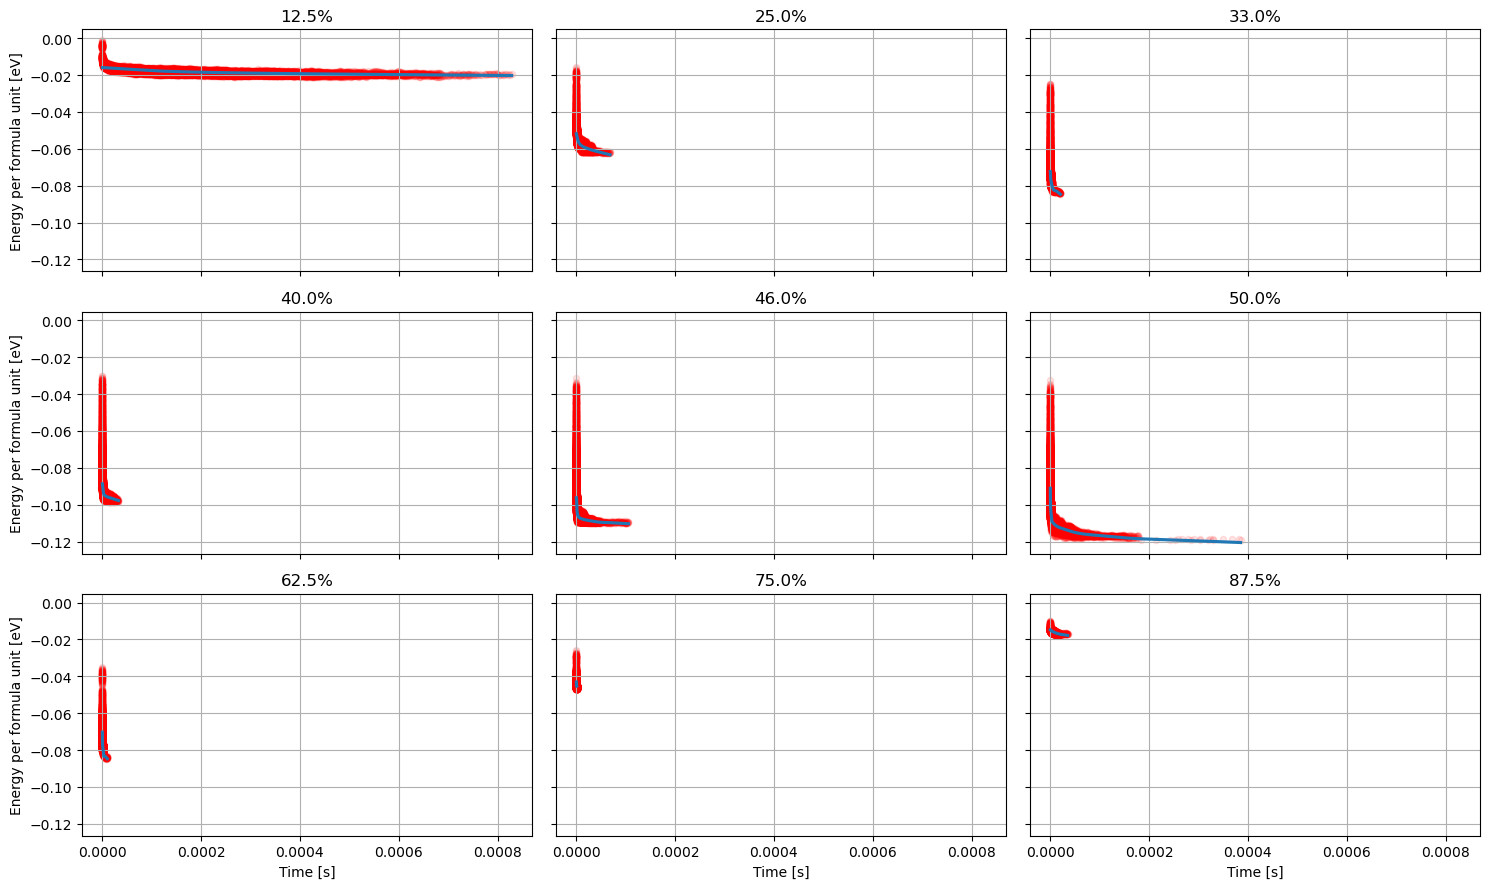

In [23]:
# Energy subplots per concentration
concs = sorted(energies_and_time.keys(), key=float)
n = len(concs)
cols = min(3, n)               # choose columns (adjust)
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 3*rows), sharex=True, sharey=True)
axes_flat = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

for i, conc in enumerate(concs):
    ax = axes_flat[i]
    df = energies_and_time[conc]
    
    # plot per-subplot (no CI fill)
    sns.regplot(x=df['time'], y=df['energy_per_formula_unit'], ax=ax, scatter_kws={'s':20, 'alpha':0.1, 'color':'red'}, ci=95, order=1, lowess=True)

    # add lineplot for bad regression 
    #if conc == '12.5':
        #time = df['time in 1e+00 s'].round(6)
        #sns.lineplot(x=time, y=df['MSD-Li'], ax=ax, color='green', estimator='mean', errorbar=('ci', 95), label='_nolegend_')   

    ax.set_title(f'{conc}%')

    #ax.set_xlim(0, 2e-5)
    #ax.set_ylim(0, 40)
    ax.grid(True)

for ax in axes.flat:
    ax.set(xlabel='Time [s]', ylabel=f'Energy per formula unit [eV]')

# Hide x labels and tick labels for all plots that are not 
for ax in axes.flat:
    ax.label_outer()

plt.legend([], [], frameon=False)
plt.tight_layout()
fig.savefig(f'{simulation_folder}kmc_energy_all_concentrations_subplots.png', dpi=300, bbox_inches='tight')
plt.show()

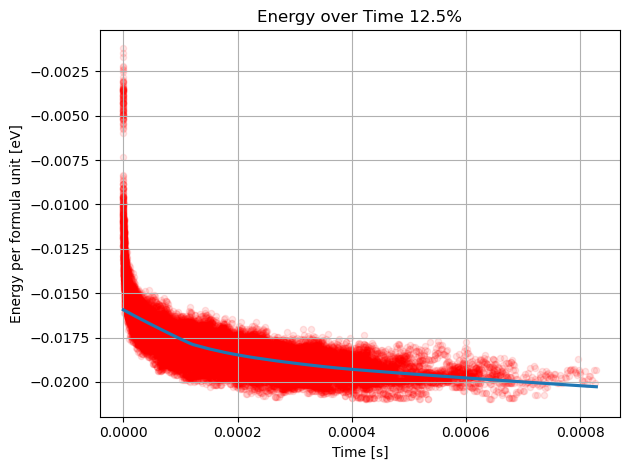

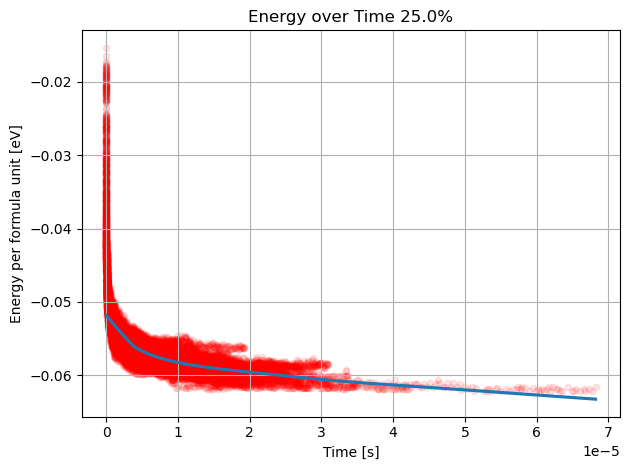

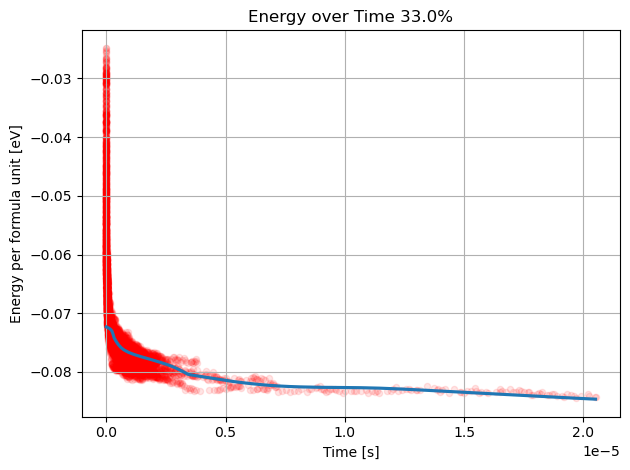

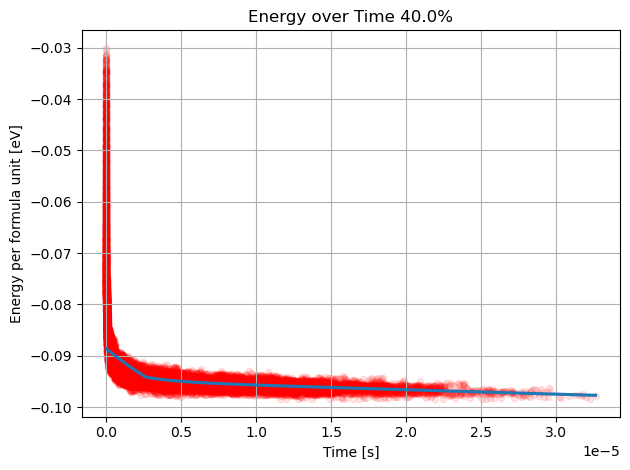

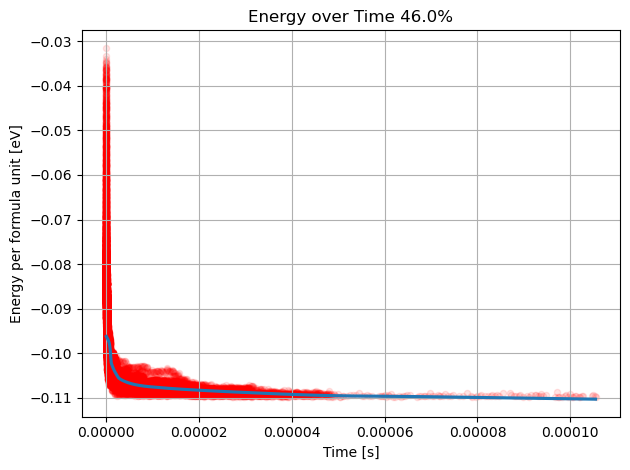

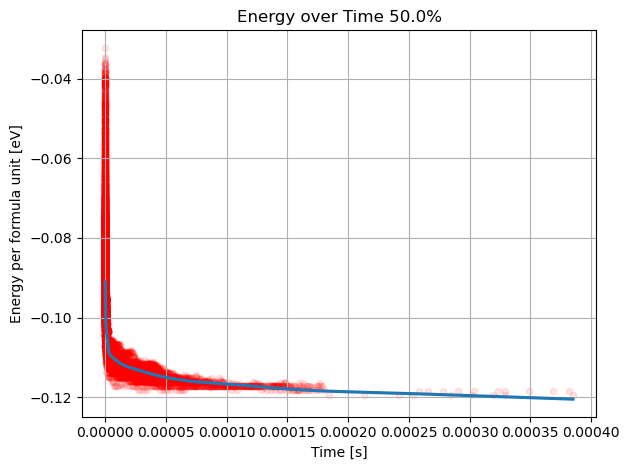

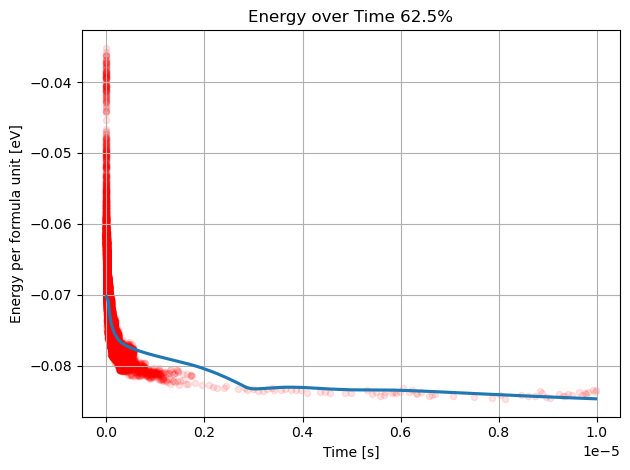

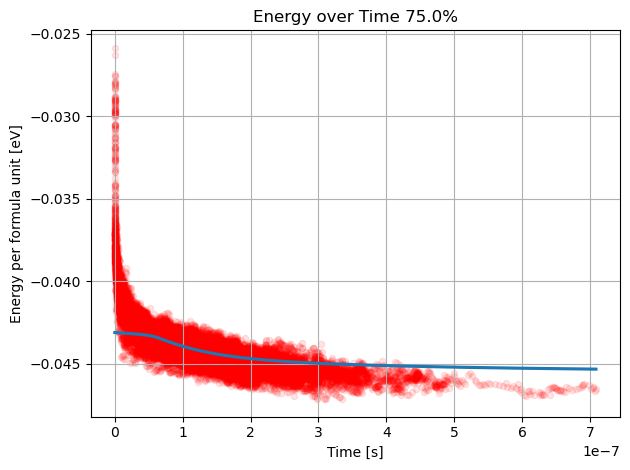

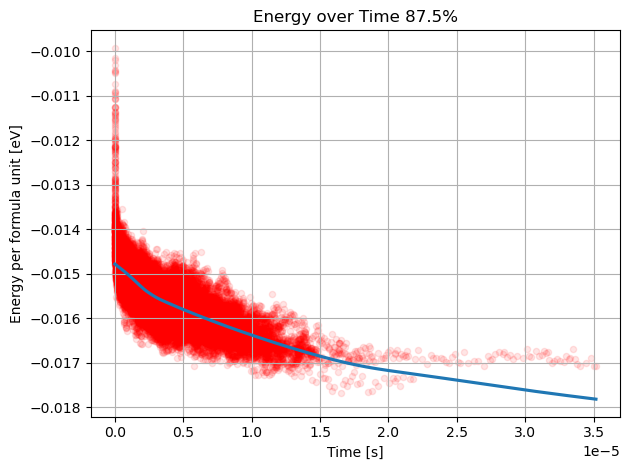

In [24]:
# MSD but all concentrations individual plots
for conc in sorted(energies_and_time.keys(), key=float):
    df = energies_and_time[conc]
    sns.regplot(x=df['time'], y=df['energy_per_formula_unit'], scatter_kws={'s':20, 'alpha':0.1, 'color':'red'}, ci=95, order=1, lowess=True)
    plt.xlabel('Time [s]')
    plt.ylabel(f'Energy per formula unit [eV]')
    plt.title(f'Energy over Time {conc}%')
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'{simulation_folder}kmc_energy_{conc}.png', dpi=300)
    plt.show()